In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import cross_validation,ensemble,metrics
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

E:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
data = pd.read_csv('lenta-ru-news.csv')

In [6]:
data.head(1)

,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество


In [7]:
test_data = data.head(100)

In [8]:
def get_data(url):
    
    date = re.findall('\d\d\d\d\/\d\d\/\d\d', url)[0]
    date = datetime.strptime(date, '%Y/%m/%d')
    return date

In [9]:
test_data['date'] = test_data['url'].apply(get_data)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
test_data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество,2018-12-14
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды,2018-12-15
2,https://lenta.ru/news/2018/12/15/disneyland/,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Мир,2018-12-15
3,https://lenta.ru/news/2018/12/15/usa25/,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,Политика,2018-12-15
4,https://lenta.ru/news/2018/12/15/integrity/,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Общество,2018-12-15
5,https://lenta.ru/news/2018/12/15/sobor/,Архиепископ канонической УПЦ отказался прийти ...,Архиепископ канонической Украинской православн...,Бывший СССР,Украина,2018-12-15
6,https://lenta.ru/news/2018/12/15/skrepy/,Российскую молодежь предложили обучать духовны...,Российская молодежь лучше усвоит духовные ценн...,Интернет и СМИ,Coцсети,2018-12-15
7,https://lenta.ru/news/2018/12/15/skripal/,Полицейские из Солсбери описали одеревеневшего...,"Полицейские Алекс Коллинс и Трейси Холлоуэй, о...",Мир,Общество,2018-12-15
8,https://lenta.ru/news/2018/12/15/tu160/,Полет российских бомбардировщиков над Карибски...,Минобороны опубликовало на YouTube видео полет...,Мир,Политика,2018-12-15
9,https://lenta.ru/news/2018/12/15/zrk/,В Минобороны раскрыли многомиллионные хищения ...,Директора завода «Электроприбор» Муталиба Эмир...,Силовые структуры,Следствие и суд,2018-12-15


# Tfidf

In [11]:
test_data['title'].tail(2)

98       Новая прическа Мелании Трамп насмешила публику
99    Финляндия закрыла программу изучения русского ...
Name: title, dtype: object

In [12]:
vectorizer=TfidfVectorizer(analyzer='word',
                           stop_words=[],
                           lowercase=False,
                           ngram_range=(1, 2),
                           min_df=15
                           )

In [13]:
vectorizer.fit_transform(data['title'])

<739351x62308 sparse matrix of type '<class 'numpy.float64'>'
	with 5662735 stored elements in Compressed Sparse Row format>

In [14]:
features = list(vectorizer.get_feature_names())

In [15]:
# models_fin = [('regret',LogisticRegression(C=1.97,solver='liblinear'))]

In [32]:
model = LogisticRegression(C=1.97,solver='liblinear')
# model = xgb.XGBClassifier(base_score=0.1,learning_rate=0.1,n_estimators=140)
models = [('regret',LogisticRegression(C=1.97,solver='liblinear')),('tree',RandomForestClassifier(oob_score=True))]
models += [('xgBoost',xgb.XGBClassifier(base_score=0.1,learning_rate=0.1,n_estimators=140))]

In [33]:
models

[('regret',
  LogisticRegression(C=1.97, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('tree',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
              oob_score=True, random_state=None, verbose=0, warm_start=False)),
 ('xgBoost',
  XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
         max_depth=3, min_child_weight=1, missing=None, n_estimators=140,
         n_jobs=1, nthread=None, objective='bin

In [34]:
X_train = data.tail(5000)['title']
X_train.fillna('undefined')
X_train_ve=vectorizer.fit_transform(X_train)
X_train_arr=X_train_ve.toarray()
X_test = data.head(1000)['title']
X_test_ve=vectorizer.transform(X_test)
X_test_arr=X_test_ve.toarray()

In [35]:
y_train = data.tail(5000)['topic']
y_train.fillna('undefined')
y_train = np.array(y_train)
y_test = data.head(1000)['topic']
y_test = np.array(y_test)

In [36]:
for name, model in models:
    print(name)
    model.fit(X_train_arr, y_train)
    result = model.predict( X_test_arr)

    print ('train - ',model.score(X_train_arr, y_train))
    print ('test - ',metrics.accuracy_score(y_test,result))
    print (metrics.classification_report (y_test,result))
    print (metrics.confusion_matrix (y_test,result))

regret
train -  0.627
test -  0.18
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
           Бизнес       0.00      0.00      0.00         1
      Бывший СССР       0.00      0.00      0.00        72
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        67
   Интернет и СМИ       0.22      0.03      0.05        79
         Культура       0.00      0.00      0.00        71
              Мир       0.26      0.30      0.28       135
  Наука и техника       0.00      0.00      0.00        64
      Путешествия       0.00      0.00      0.00        32
           Россия       0.16      0.81      0.26       156
Силовые структуры       0.00      0.00      0.00        51
            Спорт       0.00      0.00      0.00       101
         Ценности       0.00      0.00      0.00        40
        Экономика       0.36      0.12      0.18       104

      avg / total  

E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
E:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train -  0.7232
test -  0.178
                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
           Бизнес       0.00      0.00      0.00         1
      Бывший СССР       0.00      0.00      0.00        72
              Дом       0.00      0.00      0.00        26
         Из жизни       0.00      0.00      0.00        67
   Интернет и СМИ       0.29      0.09      0.14        79
         Культура       0.00      0.00      0.00        71
              Мир       0.24      0.30      0.26       135
  Наука и техника       0.00      0.00      0.00        64
      Путешествия       0.00      0.00      0.00        32
           Россия       0.16      0.76      0.27       156
Силовые структуры       0.00      0.00      0.00        51
            Спорт       0.00      0.00      0.00       101
         Ценности       0.00      0.00      0.00        40
        Экономика       0.19      0.12      0.14       104

      avg / total       

E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
features = list(vectorizer.get_feature_names())
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(models[2][1].get_booster().get_fscore())
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values(ascending=True,inplace=True)
print(ts)

index
отставку        1
человека        1
более           1
до              1
день            1
Федералы        2
дома            2
денег           2
СПС             2
помощь          2
декабря         2
ОБСЕ            2
Российский      3
при             3
погиб           3
выборах         3
of New          3
об              3
кандидата       4
50              4
Масхадов        4
Доренко         4
выборы          4
что             5
Примаков        5
Минюст          5
нашли           5
Грузии          5
российских      5
99              5
             ... 
банк           26
нефть          26
Сети           27
нефти          30
будет          33
газ            35
Чечне          37
интернет       37
сайт           37
рублей         39
МВФ            42
2000           44
Интернета      47
от             48
Российские     49
Россия         50
для            57
Москве         60
долларов       64
Microsoft      65
Интернет       65
по             66
США            67
не             72
Пути

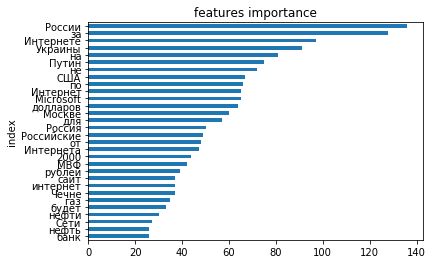

In [39]:
ts.tail(30).plot(kind="barh", title=("features importance"))

In [40]:
model.classes_

array(['Интернет и СМИ', 'Мир', 'Россия', 'Спорт', 'Экономика'], dtype=object)

In [45]:
ts = pd.DataFrame(columns=models[0][1].classes_,data=np.transpose(models[0][1].coef_),index=vectorizer.get_feature_names())
ts

,Интернет и СМИ,Мир,Россия,Спорт,Экономика
10,0.223427,-0.052102,-0.770408,-0.335821,1.065549
100,-0.497799,0.177232,0.297175,-0.295447,-0.049563
15,-0.850741,-0.359059,0.328024,0.985288,0.171504
20,-0.980287,0.369647,-0.937033,-0.261685,1.434481
2000,2.824280,-0.395429,-1.290743,-0.888245,-0.782085
2000 года,-0.021406,-0.480062,0.641243,-0.150539,0.273953
300,0.439985,0.722419,-0.073699,-0.228050,-0.932340
40,-0.620836,0.254261,-0.907616,0.793826,0.849162
50,-0.375629,0.920228,-0.146311,-0.218053,-0.494746
99,1.735407,-1.547017,0.767238,-0.242805,-1.425773


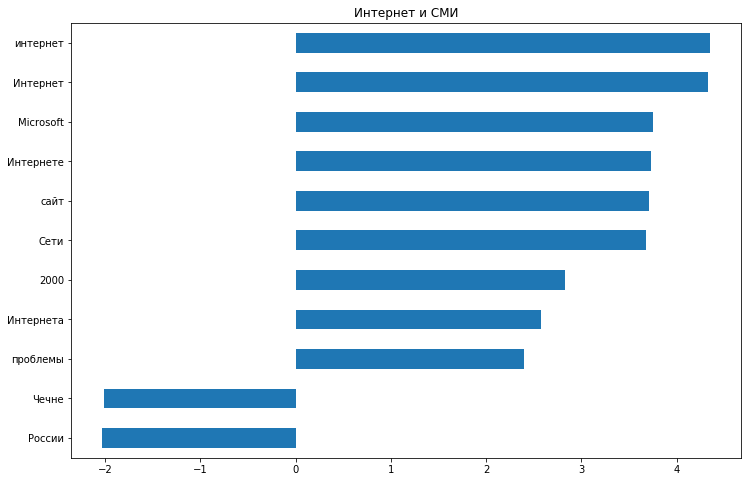

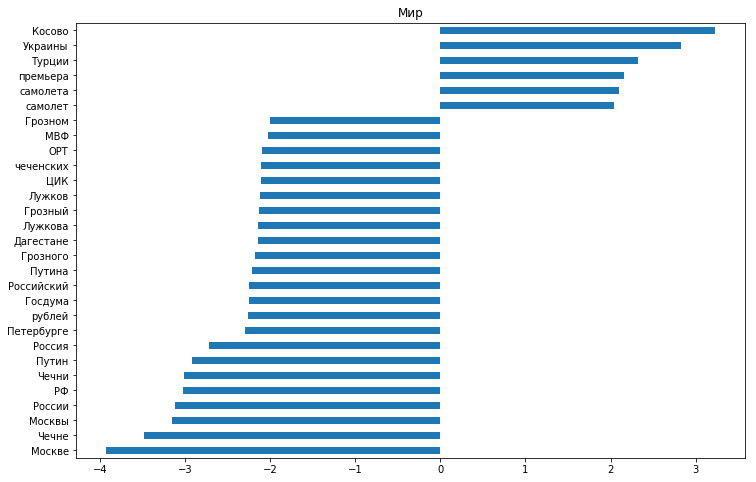

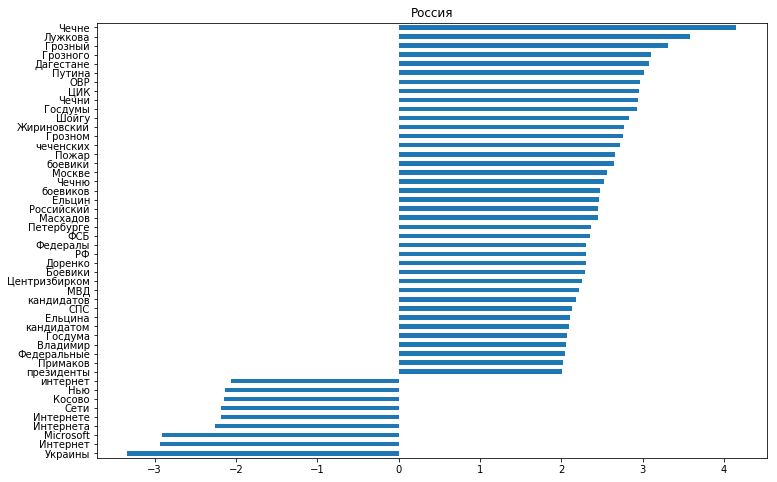

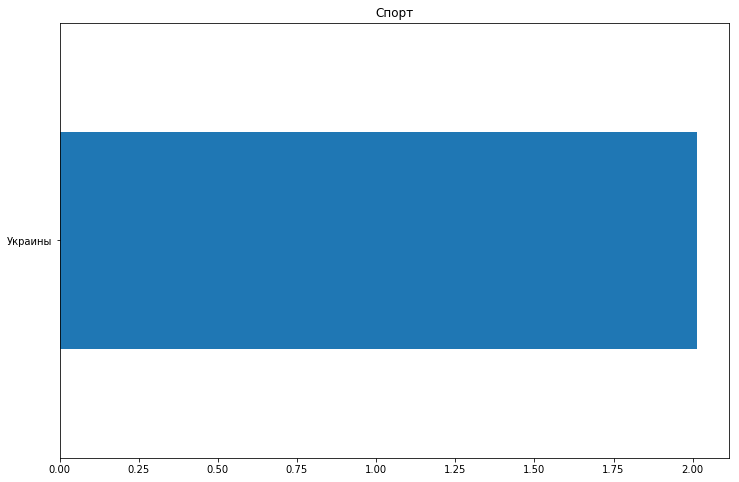

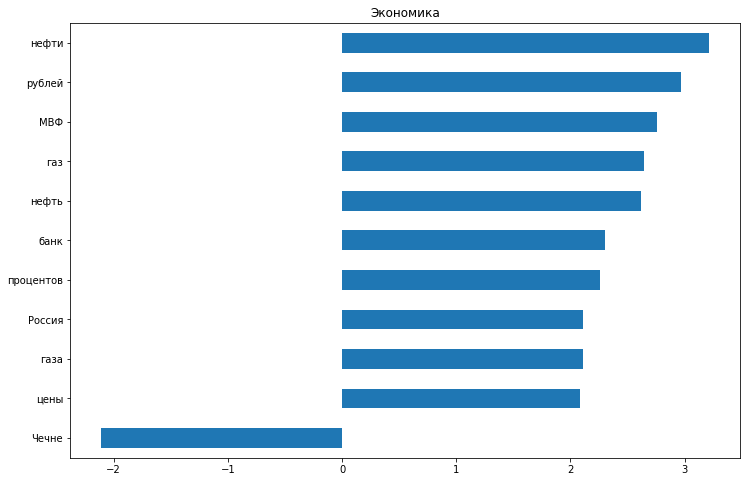

In [46]:
for c in ts.columns:
    plt.figure(figsize = (12, 8))
    ts[c][(ts[c] > 2) | (ts[c] < -2)].sort_values().plot(kind="barh", title=(c))

# experiments

In [38]:
test_data.iloc[2,:]
# ['text']

url           https://lenta.ru/news/2018/12/15/disneyland/
title         Обнаружено самое счастливое место на планете
text     Сотрудники социальной сети Instagram проанализ...
topic                                          Путешествия
tags                                                   Мир
Name: 2, dtype: object